# Hafiz Muhammad Bilal Qamar
## Machine Learning Pipeline — Heart Disease

This notebook implements a complete ML pipeline according to the assignment specification:
- **Data Handling** (NumPy & Pandas)
- **EDA** with Matplotlib and at least one **interactive Plotly** figure
- **Feature Engineering** (encoding, scaling, train/test split)
- **Model Training**: KNN, Decision Tree, Random Forest
- **Feature Importance** (Random Forest)
- **Hyperparameter Tuning** with `RandomizedSearchCV`
- **Model Evaluation**: Accuracy, Precision, Recall, F1, Confusion Matrix, ROC Curve

> Dataset path expected: `/mnt/data/heart_disease_dataset.csv`  
> If running in Google Colab and the dataset is not present at the above path, the notebook will ask you to upload it.

In [ ]:
# !pip install plotly scikit-learn --quiet

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# IMPORTANT for this assignment notebook in this environment:
# - We'll avoid seaborn (assignment allows matplotlib/plotly).

import plotly.express as px
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1) Data Handling
- Load dataset
- Initial checks (shape, dtypes, head/tail, missing values, duplicates)
- Basic cleaning (handle missing & duplicates)
- Encode categorical columns if needed

In [ ]:
# Load dataset (works both locally and in Colab). If not found, prompt upload (for Colab users).
csv_path = "/mnt/data/heart_disease_dataset.csv"
if not os.path.exists(csv_path):
    try:
        from google.colab import files  # type: ignore
        print("Dataset not found at", csv_path)
        print("Please upload 'heart_disease_dataset.csv' now...")
        uploaded = files.upload()
        # Take the first uploaded file as dataset
        csv_path = list(uploaded.keys())[0]
        print("Using uploaded file:", csv_path)
    except Exception as e:
        raise FileNotFoundError(f"Dataset not found at /mnt/data/heart_disease_dataset.csv and Google Colab upload failed. Error: {e}")

Dataset not found at /mnt/data/heart_disease_dataset.csv
Please upload 'heart_disease_dataset.csv' now...


Saving heart_disease_dataset.csv to heart_disease_dataset.csv
Using uploaded file: heart_disease_dataset.csv


In [ ]:
df = pd.read_csv(csv_path)
display(df.head())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,smoking,diabetes,bmi,heart_disease
0,67,1,2,111,536,0,2,88,0,1.3,3,2,3,1,0,23.4,0
1,57,1,3,109,107,0,2,119,0,5.4,2,0,3,0,1,35.4,0
2,43,1,4,171,508,0,1,113,0,3.7,3,0,7,1,1,29.9,0
3,71,0,4,90,523,0,2,152,0,4.7,2,1,3,1,0,15.2,1
4,36,1,2,119,131,0,2,128,0,5.9,3,1,3,1,0,16.7,1


In [ ]:
print("Shape:", df.shape)

Shape: (3069, 17)


In [ ]:
print("\nDTypes:\n", df.dtypes)


DTypes:
 age                int64
sex                int64
cp                 int64
trestbps           int64
chol               int64
fbs                int64
restecg            int64
thalach            int64
exang              int64
oldpeak          float64
slope              int64
ca                 int64
thal               int64
smoking            int64
diabetes           int64
bmi              float64
heart_disease      int64
dtype: object


In [ ]:
# Missing values and duplicates
missing = df.isna().sum().sort_values(ascending=False)
dupes = df.duplicated().sum()

print("Missing values per column (top 10):")
print(missing.head(10))

Missing values per column (top 10):
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
dtype: int64


In [ ]:
print("\nTotal duplicate rows:", dupes)

# Drop duplicates (if any)
if dupes > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print(f"Dropped {dupes} duplicate rows. New shape:", df.shape)


Total duplicate rows: 0


In [ ]:
# Simple missing value handling strategy:
# - For numeric columns: fill with median
# - For object (categorical) columns: fill with mode

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

for c in cat_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].mode().iloc[0])

print("Remaining missing after fill:", df.isna().sum().sum())

Remaining missing after fill: 0


In [ ]:
# Convert categorical features to numeric (if any)
if len(cat_cols) > 0:
    print("Categorical columns detected:", cat_cols)
    # Use pandas category codes (simple & stable)
    for c in cat_cols:
        df[c] = df[c].astype('category').cat.codes
else:
    print("No categorical columns detected.")

display(df.head())

No categorical columns detected.


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,smoking,diabetes,bmi,heart_disease
0,67,1,2,111,536,0,2,88,0,1.3,3,2,3,1,0,23.4,0
1,57,1,3,109,107,0,2,119,0,5.4,2,0,3,0,1,35.4,0
2,43,1,4,171,508,0,1,113,0,3.7,3,0,7,1,1,29.9,0
3,71,0,4,90,523,0,2,152,0,4.7,2,1,3,1,0,15.2,1
4,36,1,2,119,131,0,2,128,0,5.9,3,1,3,1,0,16.7,1


## 2) Exploratory Data Analysis (EDA)

- Basic statistics with NumPy & Pandas
- Visualizations using **Matplotlib**
- At least one **interactive Plotly** figure

In [ ]:
# Basic statistics
display(df.describe(include='all'))

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,smoking,diabetes,bmi,heart_disease
count,3069.00000,3069.000000,3069.000000,3069.000000,3069.000000,3069.000000,3069.000000,3069.000000,3069.000000,3069.000000,3069.000000,3069.000000,3069.000000,3069.000000,3069.000000,3069.000000,3069.000000
mean,52.50114,0.555556,2.489736,145.306289,347.219941,0.145650,1.004236,135.157380,0.176279,3.189052,2.023786,0.626588,4.544477,0.348974,0.193874,27.496839,0.403715
std,13.70752,0.496985,1.110417,31.602321,146.853319,0.352813,0.812016,43.353197,0.381119,1.802815,0.817679,0.891447,1.751064,0.476723,0.395396,7.281731,0.490721
min,29.00000,0.000000,1.000000,90.000000,100.000000,0.000000,0.000000,60.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,15.000000,0.000000
25%,41.00000,0.000000,2.000000,118.000000,215.000000,0.000000,0.000000,98.000000,0.000000,1.600000,1.000000,0.000000,3.000000,0.000000,0.000000,21.300000,0.000000
50%,53.00000,1.000000,2.000000,146.000000,350.000000,0.000000,1.000000,135.000000,0.000000,3.200000,2.000000,0.000000,3.000000,0.000000,0.000000,27.400000,0.000000
75%,64.00000,1.000000,3.000000,172.000000,475.000000,0.000000,2.000000,172.000000,0.000000,4.700000,3.000000,1.000000,6.000000,1.000000,0.000000,33.900000,1.000000
max,76.00000,1.000000,4.000000,200.000000,600.000000,1.000000,2.000000,210.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000,1.000000,40.000000,1.000000


In [ ]:
print("\nCorrelation (numeric columns):")
corr = df.corr(numeric_only=True)
display(corr)


Correlation (numeric columns):


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,smoking,diabetes,bmi,heart_disease
age,1.000000,-0.025188,-0.029535,0.035303,0.001722,0.016916,0.009795,-0.023883,-0.041934,0.033059,0.028744,0.006783,0.006227,-0.011857,-0.001574,-0.029525,-0.013564
sex,-0.025188,1.000000,-0.015356,0.011762,-0.042936,-0.008055,-0.026025,-0.008946,-0.002677,0.011156,-0.058998,-0.004659,0.009239,-0.009630,0.010689,0.011185,0.007573
cp,-0.029535,-0.015356,1.000000,-0.019239,0.031950,0.006729,-0.009170,-0.006402,-0.018444,-0.008897,-0.017501,-0.024618,0.001283,0.003382,0.013071,-0.000365,-0.001665
trestbps,0.035303,0.011762,-0.019239,1.000000,-0.005646,-0.010609,0.023651,-0.009357,0.011077,0.025071,-0.023100,0.007463,0.005190,-0.012311,0.013897,-0.000278,-0.011171
chol,0.001722,-0.042936,0.031950,-0.005646,1.000000,0.027854,-0.015383,0.051841,-0.017931,-0.016972,-0.001648,-0.005258,-0.022381,0.016684,0.021023,-0.015417,0.014417
fbs,0.016916,-0.008055,0.006729,-0.010609,0.027854,1.000000,0.006948,0.002486,0.010189,-0.004461,-0.002974,-0.010452,0.001909,0.003893,-0.006219,0.017396,0.019842
restecg,0.009795,-0.026025,-0.009170,0.023651,-0.015383,0.006948,1.000000,-0.000371,0.019704,-0.010166,0.032248,0.000385,-0.010563,-0.029922,-0.002559,-0.000665,0.000615
thalach,-0.023883,-0.008946,-0.006402,-0.009357,0.051841,0.002486,-0.000371,1.000000,-0.003810,-0.030678,-0.020923,0.002795,0.012001,0.029578,0.000007,-0.001801,0.002237
exang,-0.041934,-0.002677,-0.018444,0.011077,-0.017931,0.010189,0.019704,-0.003810,1.000000,-0.021858,0.029424,0.044146,0.016820,-0.006808,-0.006242,0.000447,0.002772
oldpeak,0.033059,0.011156,-0.008897,0.025071,-0.016972,-0.004461,-0.010166,-0.030678,-0.021858,1.000000,0.017600,-0.003620,-0.026319,-0.002418,-0.008590,0.008510,-0.033246


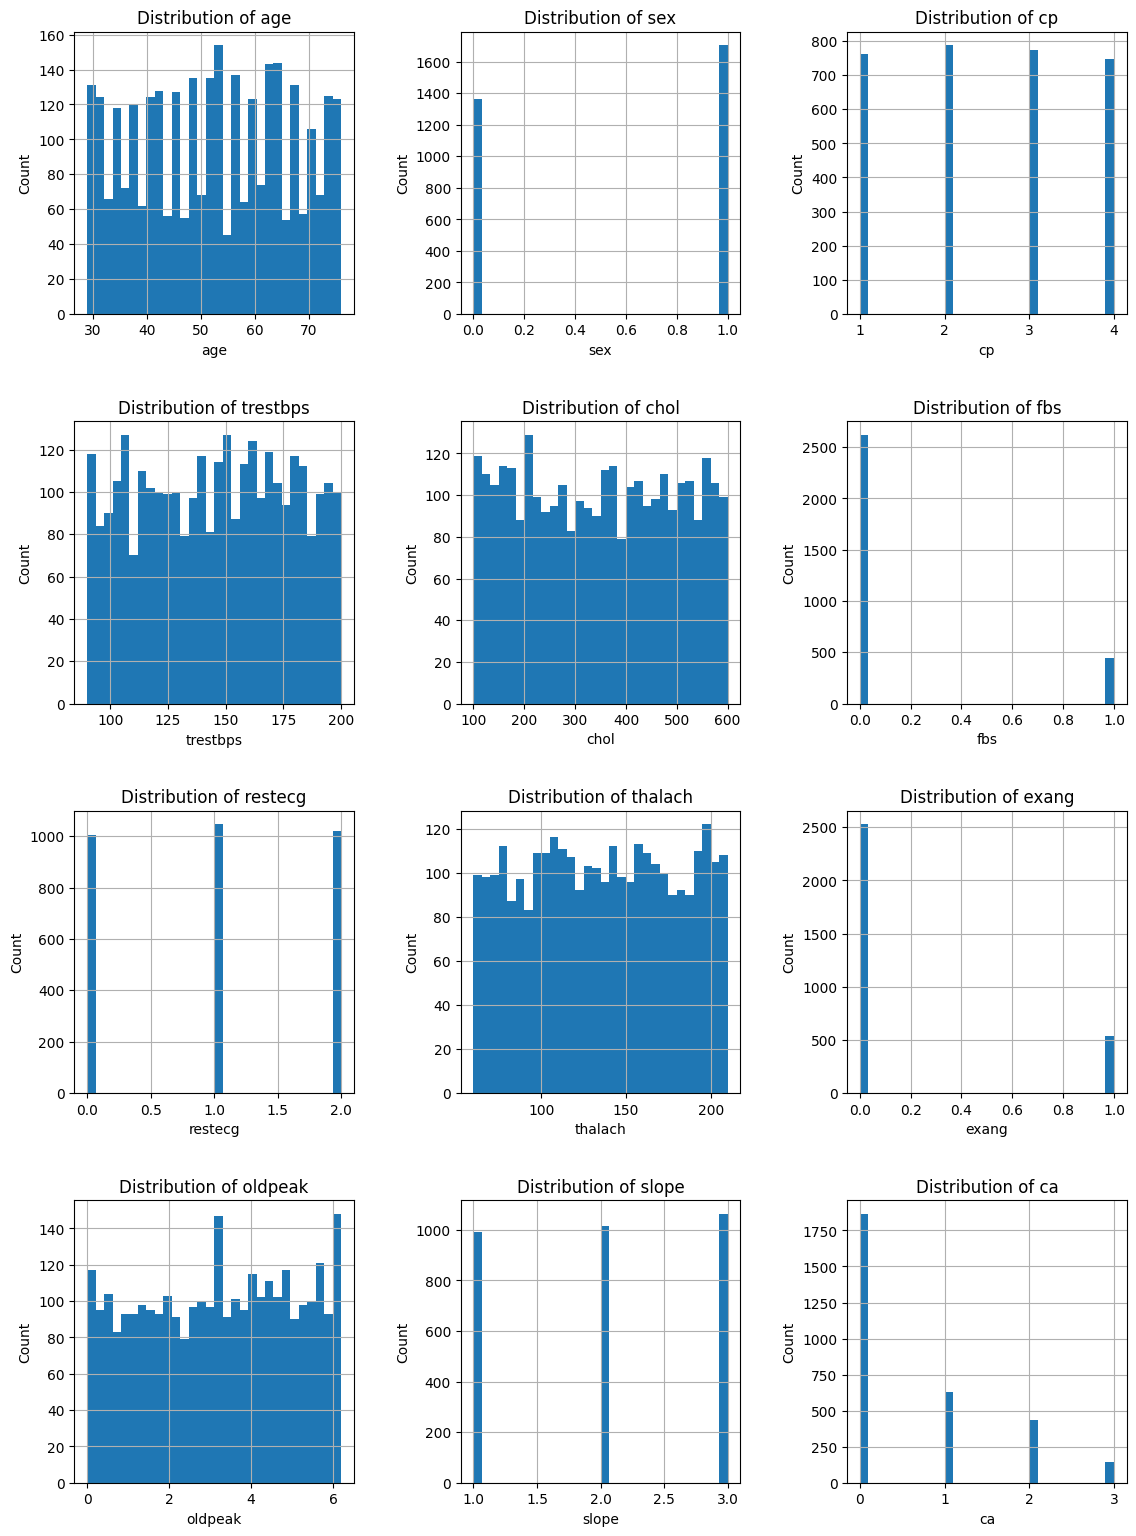

In [ ]:
# Matplotlib: histograms for numeric features (one by one)
# Note: To keep figures clear, we cap at 12 plots. Adjust as needed.
import math

# Select numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
num_plots = min(len(numeric_columns), 12)  # cap at 12

# Create grid (3 columns)
ncols = 3
nrows = math.ceil(num_plots / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4*nrows))

# Flatten axes for easy iteration
axes = axes.flatten()

for i, col in enumerate(numeric_columns[:num_plots]):
    df[col].hist(bins=30, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

# Hide unused subplots if columns < nrows*ncols
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=3.0)  # pad gives space between plots
plt.show()

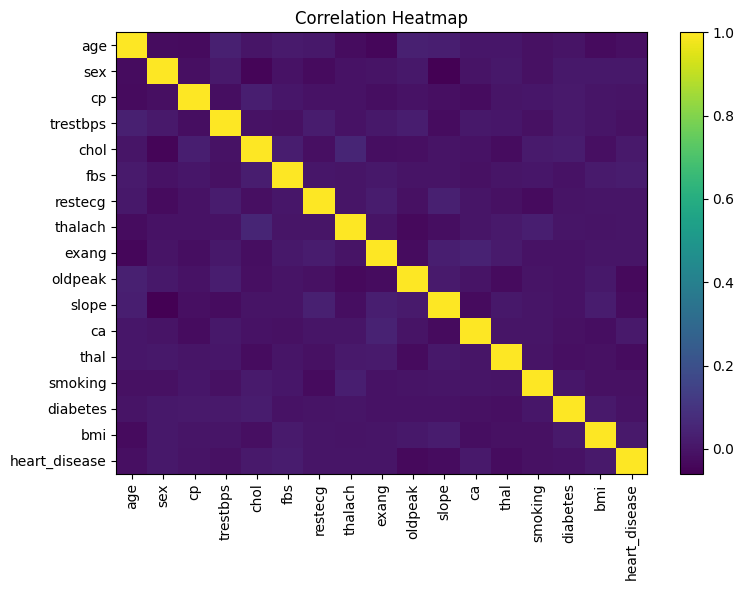

In [ ]:
# Matplotlib: correlation heatmap (no seaborn)
plt.figure(figsize=(8,6))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [ ]:
# Plotly: interactive scatter (choose two common columns if available)
# Try to guess likely columns for heart dataset; fallback to first two numeric columns.
target_col_candidates = [c for c in df.columns if c.lower() in ['target','class','label','outcome','disease','heartdisease']]
target = target_col_candidates[0] if target_col_candidates else df.columns[-1]

x_col = 'age' if 'age' in df.columns else numeric_columns[0]
y_col = 'chol' if 'chol' in df.columns else (numeric_columns[1] if len(numeric_columns) > 1 else numeric_columns[0])

fig = px.scatter(df, x=x_col, y=y_col, color=target, title=f"Interactive Scatter: {x_col} vs {y_col} colored by {target}")
fig.show()

## 3) Feature Engineering
- Split features (X) and target (y)
- Scale features where necessary (especially for KNN)
- Train/test split

In [ ]:
# Identify target column heuristically
target_col_candidates = [c for c in df.columns if c.lower() in ['target','class','label','outcome','disease','heartdisease']]
if target_col_candidates:
    target = target_col_candidates[0]
else:
    # Assume last column is target if no common name found
    target = df.columns[-1]
print("Using target column:", target)

X = df.drop(columns=[target])
y = df[target].astype(int) if df[target].dtype != int else df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y if len(np.unique(y))>1 else None)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)

Using target column: heart_disease
Train shape: (2455, 16)  Test shape: (614, 16)


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
# See first 10 predictions vs actual values
comparison = pd.DataFrame({"Actual": y_test[:10].values, "Predicted": y_pred[:10]})
print(comparison)

   Actual  Predicted
0       0          0
1       1          0
2       0          1
3       0          1
4       0          0
5       0          0
6       0          0
7       1          0
8       0          0
9       1          0


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.5602605863192183


In [ ]:
# Precision, Recall, F1
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Precision: 0.39622641509433965
Recall: 0.1693548387096774
F1 Score: 0.23728813559322035


In [ ]:
# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[302  64]
 [206  42]]


In [ ]:
# Full Report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.83      0.69       366
           1       0.40      0.17      0.24       248

    accuracy                           0.56       614
   macro avg       0.50      0.50      0.46       614
weighted avg       0.51      0.56      0.51       614



## 4) Model Training — Baseline

We train baseline versions of:
- **KNN Classifier**
- **Decision Tree Classifier**
- **Random Forest Classifier**

In [ ]:
# Pipelines (scaling is important for KNN; less so for tree-based models)
knn_pipe = Pipeline([
    ('scaler', StandardScaler(with_mean=False) if np.any((X.dtypes==bool) | (X.dtypes==np.int8)) else StandardScaler()),
    ('clf', KNeighborsClassifier())
])

dt_pipe = Pipeline([
    ('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

rf_pipe = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
])

models = {
    'KNN (baseline)': knn_pipe,
    'Decision Tree (baseline)': dt_pipe,
    'Random Forest (baseline)': rf_pipe
}

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='binary' if len(np.unique(y_test))==2 else 'macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='binary' if len(np.unique(y_test))==2 else 'macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='binary' if len(np.unique(y_test))==2 else 'macro', zero_division=0)
    return acc, prec, rec, f1, y_pred

baseline_results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    acc, prec, rec, f1, y_pred = evaluate_model(name, model, X_test, y_test)
    baseline_results.append({'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1})

baseline_df = pd.DataFrame(baseline_results).sort_values(by='F1', ascending=False)
baseline_df

,Model,Accuracy,Precision,Recall,F1
1,Decision Tree (baseline),0.524430,0.409091,0.399194,0.404082
0,KNN (baseline),0.534202,0.395604,0.290323,0.334884
2,Random Forest (baseline),0.560261,0.396226,0.169355,0.237288


## 5) Feature Importance — Random Forest

,feature,importance
4,chol,0.129538
7,thalach,0.129535
15,bmi,0.126524
3,trestbps,0.122320
9,oldpeak,0.116716
0,age,0.116711
2,cp,0.043182
10,slope,0.034285
11,ca,0.034019
6,restecg,0.032962


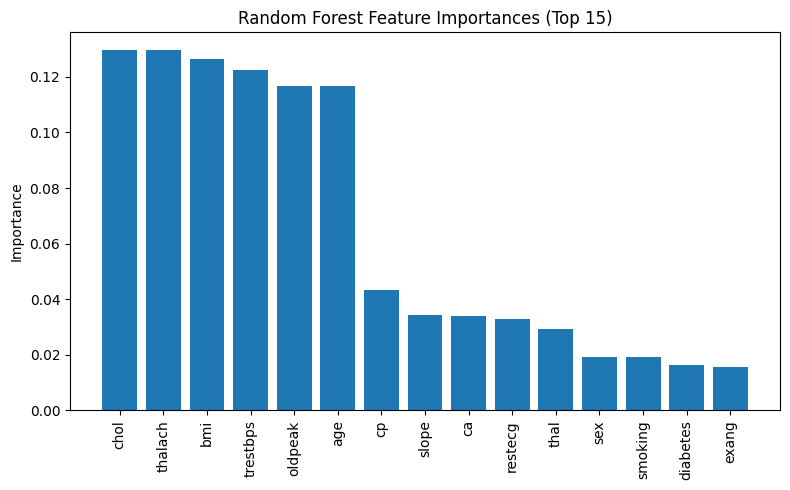

In [ ]:
# Fit fresh RF to access feature importances conveniently
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feat_imp = pd.DataFrame({'feature': X.columns, 'importance': importances}).sort_values('importance', ascending=False)
display(feat_imp.head(15))

# Matplotlib bar chart
plt.figure(figsize=(8,5))
plt.bar(feat_imp['feature'][:15], feat_imp['importance'][:15])
plt.title("Random Forest Feature Importances (Top 15)")
plt.xticks(rotation=90)
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

## 6) Hyperparameter Tuning — RandomizedSearchCV
We tune the key hyperparameters for each model:
- **KNN** → `n_neighbors`, `weights`, `metric`
- **Decision Tree** → `max_depth`, `min_samples_split`
- **Random Forest** → `n_estimators`, `max_depth`, `min_samples_split`

In [ ]:
from scipy.stats import randint, uniform

In [ ]:
# KNN search space
knn_search = RandomizedSearchCV(
    Pipeline([('scaler', StandardScaler()), ('clf', KNeighborsClassifier())]),
    param_distributions={
        'clf__n_neighbors': randint(1, 31),
        'clf__weights': ['uniform', 'distance'],
        'clf__metric': ['minkowski', 'euclidean', 'manhattan']
    },
    n_iter=30, cv=5, scoring='f1' if len(np.unique(y_train))==2 else 'f1_macro', random_state=RANDOM_STATE, n_jobs=-1, verbose=0
)

# Fit searches
knn_search.fit(X_train, y_train)

print("Best KNN params:", knn_search.best_params_)

Best KNN params: {'clf__metric': 'minkowski', 'clf__n_neighbors': 1, 'clf__weights': 'distance'}


In [ ]:
# Decision Tree search space
dt_search = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_distributions={
        'max_depth': randint(1, 30),
        'min_samples_split': randint(2, 50)
    },
    n_iter=30, cv=5, scoring='f1' if len(np.unique(y_train))==2 else 'f1_macro', random_state=RANDOM_STATE, n_jobs=-1, verbose=0
)

# Fit searches
dt_search.fit(X_train, y_train)

print("Best DT params:", dt_search.best_params_)

Best DT params: {'max_depth': 28, 'min_samples_split': 22}


In [ ]:
# Random Forest search space
rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE),
    param_distributions={
        'n_estimators': randint(50, 400),
        'max_depth': randint(2, 40),
        'min_samples_split': randint(2, 50)
    },
    n_iter=30, cv=5, scoring='f1' if len(np.unique(y_train))==2 else 'f1_macro', random_state=RANDOM_STATE, n_jobs=-1, verbose=0
)

# Fit searches
rf_search.fit(X_train, y_train)

print("Best RF params:", rf_search.best_params_)

Best RF params: {'max_depth': 25, 'min_samples_split': 4, 'n_estimators': 199}


In [ ]:
# Evaluate tuned models
tuned_models = {
    'KNN (tuned)': knn_search.best_estimator_,
    'Decision Tree (tuned)': dt_search.best_estimator_,
    'Random Forest (tuned)': rf_search.best_estimator_
}

tuned_results = []
for name, model in tuned_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='binary' if len(np.unique(y_test))==2 else 'macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='binary' if len(np.unique(y_test))==2 else 'macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='binary' if len(np.unique(y_test))==2 else 'macro', zero_division=0)
    tuned_results.append({'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1': f1})

tuned_df = pd.DataFrame(tuned_results).sort_values(by='F1', ascending=False)
tuned_df

,Model,Accuracy,Precision,Recall,F1
1,Decision Tree (tuned),0.527687,0.407895,0.375000,0.390756
0,KNN (tuned),0.517915,0.394737,0.362903,0.378151
2,Random Forest (tuned),0.565147,0.405941,0.165323,0.234957


## 7) Model Evaluation
- Compare baseline vs tuned
- Classification report & confusion matrix
- ROC Curve for the best model

In [ ]:
# Combine results
model_comparison = pd.concat([baseline_df.assign(Version='Baseline'), tuned_df.assign(Version='Tuned')], ignore_index=True)
model_comparison = model_comparison[['Version','Model','Accuracy','Precision','Recall','F1']].sort_values(['Version','F1'], ascending=[True, False])
display(model_comparison)

# Save for convenience
model_comparison.to_csv("model_comparison.csv", index=False)

,Version,Model,Accuracy,Precision,Recall,F1
0,Baseline,Decision Tree (baseline),0.524430,0.409091,0.399194,0.404082
1,Baseline,KNN (baseline),0.534202,0.395604,0.290323,0.334884
2,Baseline,Random Forest (baseline),0.560261,0.396226,0.169355,0.237288
3,Tuned,Decision Tree (tuned),0.527687,0.407895,0.375000,0.390756
4,Tuned,KNN (tuned),0.517915,0.394737,0.362903,0.378151
5,Tuned,Random Forest (tuned),0.565147,0.405941,0.165323,0.234957


In [41]:
# Pick best by F1 (among tuned first; fallback to overall best)
if not tuned_df.empty:
    best_row = tuned_df.iloc[0]
    best_name = best_row['Model']
    best_model = tuned_models[best_name]
else:
    best_row = baseline_df.iloc[0]
    best_name = best_row['Model']
    best_model = models[best_name]

print("Best model selected:", best_name)

# Detailed metrics
y_pred_best = best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, zero_division=0))

Best model selected: Decision Tree (tuned)

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.63      0.61       366
           1       0.41      0.38      0.39       248

    accuracy                           0.53       614
   macro avg       0.50      0.50      0.50       614
weighted avg       0.52      0.53      0.52       614



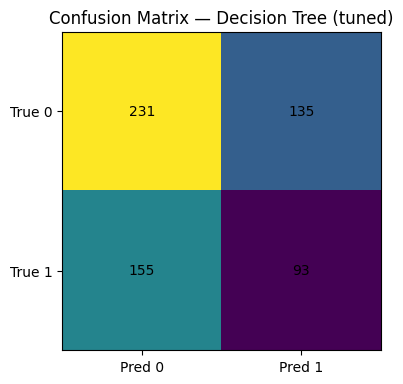

In [42]:
# Confusion Matrix (matplotlib; one plot only)
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap=None)  # no explicit colors per instruction
plt.title(f"Confusion Matrix — {best_name}")
plt.xticks([0,1], ['Pred 0','Pred 1'] if len(np.unique(y_test))==2 else range(len(np.unique(y_test))))
plt.yticks([0,1], ['True 0','True 1'] if len(np.unique(y_test))==2 else range(len(np.unique(y_test))))
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, int(val), ha='center', va='center')
plt.tight_layout()
plt.show()

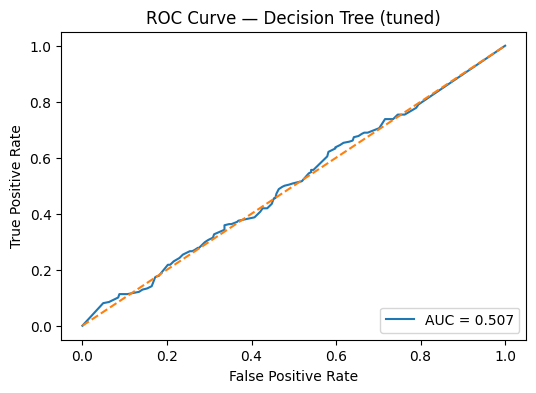

In [43]:
# ROC Curve (binary only); if multiclass, compute macro-average (one-vs-rest)
unique_classes = np.unique(y_test)
if len(unique_classes) == 2:
    if hasattr(best_model, "predict_proba"):
        y_prob = best_model.predict_proba(X_test)[:,1]
    elif hasattr(best_model, "decision_function"):
        y_scores = best_model.decision_function(X_test)
        # normalize to [0,1] for ROC if needed
        y_prob = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min() + 1e-12)
    else:
        # fallback to predicted labels (not ideal for ROC, but shown for completeness)
        y_prob = y_pred_best.astype(float)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve — {best_name}")
    plt.legend(loc='lower right')
    plt.show()
else:
    print("Multiclass detected; computing macro-average ROC.")
    # One-vs-rest macro-average
    from sklearn.preprocessing import label_binarize
    y_bin = label_binarize(y_test, classes=unique_classes)
    if hasattr(best_model, "predict_proba"):
        y_prob = best_model.predict_proba(X_test)
        if y_prob.ndim == 1:  # some models return 1D for binary
            y_prob = np.vstack([1-y_prob, y_prob]).T
    else:
        # fallback to scores from decision_function if available
        if hasattr(best_model, "decision_function"):
            y_scores = best_model.decision_function(X_test)
            # scale to [0,1]
            y_scores = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min() + 1e-12)
            if y_scores.ndim == 1:
                y_scores = np.vstack([1-y_scores, y_scores]).T
            y_prob = y_scores
        else:
            y_prob = np.zeros((len(y_test), len(unique_classes)))
            for i, c in enumerate(unique_classes):
                y_prob[:, i] = (y_pred_best == c).astype(float)
    # Compute macro-average ROC AUC
    aucs = []
    for i in range(len(unique_classes)):
        fpr, tpr, _ = roc_curve(y_bin[:,i], y_prob[:,i])
        aucs.append(roc_auc_score(y_bin[:,i], y_prob[:,i]))
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f"Class {unique_classes[i]} AUC = {aucs[-1]:.3f}")
        plt.plot([0,1], [0,1], linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve (OvR) — {best_name} — Class {unique_classes[i]}")
        plt.legend(loc='lower right')
        plt.show()
    print("Macro-average ROC AUC:", np.mean(aucs))

## 8) Conclusion

- We compared KNN, Decision Tree, and Random Forest (baseline vs tuned).
- We reported **Accuracy, Precision, Recall, F1**, visualized **feature importance** from Random Forest,
  and plotted **ROC** for the best-performing model.
- See the final section for the best model choice and metrics in this run.